<a href="https://colab.research.google.com/github/Undercover-FCFM/Epi/blob/main/HorizonteErrante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive #Para montar su drive y que puedan leer los datos
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os
from google.colab import auth
from googleapiclient.discovery import build
# Enter the ID of the folder where the CSV file is located
folder_id = '1ko9YQpYx6S_TZHodSdXNQZvDwIwO7cF5'

In [ ]:
archivo_de_datos = "/content/drive/MyDrive/Colab Notebooks/Datos Epidemias/Puebla_pos.csv" #Aqui cambian a la ruta de donde tengan el archvio de datos en drive

Funciones de Utilidad:

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import optimize


########## Carga datos ####
def load_data(size=658,file='Puebla_pos.csv'):  #good for 47 intervals (14 days each inteval)
    df=pd.read_csv(file)
    d=np.array(df['positivo'])
    d1=d[:size]
    d_cumulative = np.cumsum(d1)
    return d1,d_cumulative

#### Grafica datos ####
def plot_data(data):
    plt.style.use('ggplot')
    #casosp=np.shape(casos) (casos)
    fig, (ax1) = plt.subplots(figsize=(10,6))
    ax1.set_title('People infected with Covid-19, Puebla')
    ax1.plot(range(len(data)),data,'r.')
    ax1.set_xlabel('Time (Days)')
    ax1.set_ylabel('Number (Persons)')
    plt.show()

### define modelo seaird con los parametros dados
def set_seaird(beta,gamma,sigma,eta,alpha,mu=0):
    def seaird(t,y):
        S,E,A,I,R,D,C = y
        N=S+E+A+I+R+D
        dSdt = -beta*(S * E/N - S*A/N- eta*S*I/N)
        dEdt = beta*S*E/N+beta*S*A/N+beta*eta*S*I/N-sigma*E
        dAdt = alpha*sigma*E-gamma*A
        dIdt = (1.-alpha)*sigma*E - gamma * I
        dRdt = gamma *(A+(1.-mu)*I)
        dDdt = gamma*mu*I
        dCdt = (1.-alpha)*sigma*E
        return np.array([dSdt, dEdt, dAdt, dIdt, dRdt, dDdt, dCdt])
    return seaird

### Ajusta el modelo en partes. El ajuste es sobre casos acumulados ###
## parametros:
# cum_data : datos de casos acumulados
# S0 : poblacion de suseptibles inicial o total de la poblacion 
# plot=True : genera graficas del ajuste
# DT=14 : Numero de dias por tramo para hacer el ajuste. Default 14 sigifica toma 7 en el pasado y 7 en el futuro para hacer el ajuste del intervalo intermedio de 14 dias
# es decir, toma 28 dias para ajustar pero le asigna el valor de los parametros a los 14 dias intermedios
 
def fit_in_parts(cum_data,S0=6000000., plot=True,*,DT=14):
    d1_cumulative = cum_data

    def Cumulative_part(t,beta,gamma,sigma,eta,alpha):  # Se define el modelo y queremos solo ajustar la parte de casos acumulados. 
        seaird = set_seaird(beta,gamma,sigma,eta,alpha,0.)
        #sol = solve_ivp(seaird,[t[0],t[-1]+1],y0,t_eval=t)
        #return sol.y[6]
        sol = odeint(seaird,y0,t,tfirst=True)  #Notar que y0 es un parametro libre que toma del entorno externo
        return sol[:,6]

    params_guess = [0.339909294,1.63162822e-01,3.62560733e+00,6.54907933e-01,4.49961836e-02]

    
    ti = 0
    tf = DT
    E0,A0,I0,R0,D0,C0 = 0.,0.,1.,0.,0.,1.
    y0=[S0,E0,A0,I0,R0,D0,C0]
    overlap=0  #En el primer intervalo no podemos tomar datos en el pasado para el ajuste
    overlap_f=int(DT/2) #Numero de datos en el futuro para ajustar
    final_data = len(cum_data)%DT
    n_intervals = int(len(cum_data)/DT)

    y0_interval=y0 # condicion inicial para realizar el ajuste y en el primer intervalo para graficar
    
    for i in range(n_intervals):
        data = d1_cumulative[ti-overlap:tf+overlap_f] #Se toman los datos tomando en cuenta el overlap del pasado y futuro para el ajuste
        t = np.arange(ti-overlap,tf+overlap_f)
        popt, pcov = optimize.curve_fit(Cumulative_part, t, data, params_guess,bounds=(0,[10,10,10,10,1.]),maxfev=5000)
        seaird = set_seaird(*popt) #definimos el modelo seird con los parametros ajustados para poder graficar
        sol = solve_ivp(seaird,[ti,tf],y0_interval,t_eval=range(ti,tf+1)) #resolvemos el modelo en este intervalo de tiempo
        if (plot==True):
            plt.plot(sol.t,sol.y[6]) #graficamos este pedazo de tiempo
            plt.xlabel('Time (Days)')
            plt.ylabel('Cumulative Infected')
        if (i==0):
            evolution = sol.y.copy() # podemos ir guardando la evolucion total (primera iteracion creamos el vector np)
            global_time = sol.t.copy()
            params = [popt.copy()] #guardamos en lista los parametros del periodo
            init_times = [ti] #guardamos los tiempos de inicio para esos parametros
        else:
            evolution = np.append(evolution,sol.y[:,1:],axis=1) # podemos ir guardando la evolucion total 
            global_time = np.append(global_time,sol.t[1:])
            params.append(popt.copy()) #guardamos en lista los parametros del periodo
            init_times.append(ti) #guardamos los tiempos de inicio para esos parametros
        #setting new interval
        ti=tf #el tiempo final ahora sera el tiempo inicial del siguiente periodo
        tf=tf+DT #el tiempo final ahora sera el tiempo finial del periodo anterior mas DT el periodo de ajuste
        overlap=int(DT/2) # podemos usar datos del pasado para ajustar este periodo . Regularizacion
        y0 = sol.y[:,-overlap] # La condicion inicial para el ajuste sera al tiempo final menos el overlap en el pasado
        y0_interval = sol.y[:,-1] # La condicion inicial para el siguiente periodo será el estado final del acutal
        params_guess = popt.copy() # le tratamos de ayudar al algorithmo de minimos cuadrados dandole los parametros actuales
        if (i==n_intervals-3 and final_data<overlap_f): #penultimo ajuste. Verificamos que overlap_f no se salga del rango
            overlap_f=final_data

        if (i==n_intervals-2):  #Ultimo pedazo de ajuste (no podemos usar mas datos del futuro)
            tf=len(d1_cumulative)-1 #el tiempo final ahora sera el tiempo finial de los datos
            overlap_f = 0 #No puede haber overlap en futuro


    if (plot==True):
        plt.scatter(range(0,len(d1_cumulative)), d1_cumulative)
        plt.show()

    #El resultado se regresa como un diccionario de python
    res = {"evolution" : evolution, "time" : global_time, "params" : np.array(params), "init_times" : np.array(init_times)} 
    return res


#En el ajuste de parametros usamos datos del pasado y futuro. Aqui solo usaremos datos del pasado
#El mayor problema encontrado es estimar el estado inicial y0 del periodo a predecir
#t_i : tiempo inicial de la prediccion
#t_f : tiempo final de la prediccion
def predict_evolution(cum_data,t_i,t_f,DT=14,*,y0=None,param_guess=None, plot=True):

    if np.any(param_guess==None):
        params_guess = [0.339909294,1.63162822e-01,3.62560733e+00,6.54907933e-01,4.49961836e-02]

    if t_i < DT:
        print("t_i : initial time must be greater or equal to DT past time used to estimate parameters. ")
        return -1

    def set_cumulative_part(y0): # A diferencia de la funcion pasada aqui se asigna y0 al definir cumulative part. No me gusta usar variables del "entorno" jeje.
        def cumulative_part(t,beta,gamma,sigma,eta,alpha):
            seaird = set_seaird(beta,gamma,sigma,eta,alpha,0.)
            #sol = solve_ivp(seaird,[t[0],t[-1]],y0,t_eval=t,method='LSODA')
            #return sol.y[6]
            sol = odeint(seaird,y0,t,tfirst=True)
            return sol[:,6]

        return cumulative_part

    if np.any(y0==None): # Si no se da un estimado del estado inicial , asumimos que es el inicio de la epidemia.
        S0=6000000.
        E0,A0,I0,R0,D0,C0 = 0.,0.,1.,0.,0.,1.
        y0=[S0,E0,A0,I0,R0,D0,C0]
        model = set_cumulative_part(y0)
        data = cum_data[0:t_i] #Si no se da un estimado inicial ajustamos usando todos los datos hasta el timepo inicial de prediccion t_i
        t = np.arange(0,t_i)
        sigma = np.ones_like(t) #Le damos el mismo peso a todos los datos. Falta experimentar dar mas peso a los ultimos datos
        #sigma[-1]=1.5
        popt, pcov = optimize.curve_fit(model, t, data, params_guess,bounds=(0,[10,10,10,10,1.]),sigma=sigma,maxfev=1000)
        seaird = set_seaird(*popt) #definimos el modelo con estos parametros
        #######
        ######## podemos graficar el ajuste junto con la prediccion #Lo triste es que la prediccion es medio pobre 
        sol = solve_ivp(seaird,[0,t_f],y0,t_eval=np.arange(0,t_f+1))
        plt.plot(sol.t,sol.y[6])
        plt.scatter(range(0,t_f),cum_data[0:t_f])
        plt.xlabel('Time (Days)')
        plt.ylabel('Cumulative Infected')
        plt.show()
        ######

        sol = solve_ivp(seaird,[0,t_i],y0,t_eval=[t_i])
        y0=sol.y[:,-1].copy() #guardamos la condicion final como posible condicion inicial para volver a llamar a la funcion con un estimado de y0
        params_guess = popt
        

    model = set_cumulative_part(y0)
    data = cum_data[t_i:t_i-DT:-1]
    t = np.arange(t_i,t_i-DT,-1)
    popt, pcov = optimize.curve_fit(model, t, data, params_guess,bounds=(0,[10,10,10,10,1.]),maxfev=1000)
    seaird = set_seaird(*popt)
    sol = solve_ivp(seaird,[t_i,t_f],y0,t_eval=range(t_i,t_f+1))
    if (plot==True):
        plt.plot(sol.t,sol.y[6])
        plt.xlabel('Time (Days)')
        plt.ylabel('Cumulative Infected')

    if (plot==True):
        plt.scatter(range(t_i,t_f), cum_data[t_i:t_f])
        plt.scatter(range(t_i-DT,t_i), cum_data[t_i-DT:t_i])
        plt.show()

    return sol.y[:,-1], popt


def save_model_fit(file):
    dat,cum_data=load_data(file=file)
    res=fit_in_parts(cum_data)
    with open('CovidModel.npy', 'wb') as f:
        np.save(f, np.array(res["params"]))
        np.save(f, np.array(res["init_times"]))

def load_seaird_params(file='CovidModel.npy'):
    with open(file, 'rb') as f:
        params = np.load(f)
        init_times = np.load(f)
        tf = init_times[-1]
    return params , init_times

def load_seaird(file='CovidModel.npy'):
    with open(file, 'rb') as f:
        params = np.load(f)
        init_times = np.load(f)
        tf = init_times[-1]


    def seaird(t,y,u=lambda t : 0.):
        S,E,A,I,R,D,C = y
        N=S+E+A+I+R+D
        mu=0.
        beta,gamma,sigma,eta,alpha = params[init_times <= t][-1]


        dSdt = -beta*(1.-u(t))*(S * E/N + S*A/N + eta*S*I/N)
        dEdt = beta*(1.-u(t))*(S*E/N+ S*A/N+ eta*S*I/N)-sigma*E
        dAdt = alpha*sigma*E-gamma*A
        dIdt = (1.-alpha)*sigma*E - gamma * I
        dRdt = gamma *(A+(1.-mu)*I)
        dDdt = gamma*mu*I
        dCdt = (1.-alpha)*sigma*E

        return np.array([dSdt, dEdt, dAdt, dIdt, dRdt, dDdt, dCdt])

    return seaird, tf

def plot_model(Model,tf,u=lambda t: 0.):
    S0=6000000.
    E0,A0,I0,R0,D0,C0 = 0.,0.,1.,0.,0.,1.
    ti=0
    y0=[S0,E0,A0,I0,R0,D0,C0]
    sol = solve_ivp(Model,[ti,tf],y0,t_eval=np.arange(ti,tf+1),args=(u,))
    plt.figure(figsize=(8, 6), dpi=80)
    plt.title("Susceptibles")
    plt.plot(sol.t,sol.y[0], label="S")
    plt.figure(figsize=(8, 6), dpi=80)
    plt.title("Infected")
    #plt.plot(sol.t,sol.y[1], label="I")
    plt.scatter(sol.t,sol.y[1])
    plt.figure(figsize=(8, 6), dpi=80)
    plt.title("Cumulative Infected")
    plt.plot(sol.t,sol.y[6])
    plt.show()



#Serie de Fourier para la función de control u
def serief(a,b,t_i,t_f,x):
    '''Calcular la serie de Fourier de una función
    a:coeficientes del coseno
    b:coeficientes del seno , el ultimo coef es el termino constante
    T:Intervalo del dominio
    '''
    T=t_f-t_i
    fourier=b[-1]
    for i, (A, B) in enumerate(zip(a,b[:-1])):
        fourier+=A*np.cos(((i+1)*np.pi*(x-t_i))/T)+B*np.sin(((i+1)*(x-t_i)*np.pi)/T)
    return fourier

#Se define una funcion para calcular los coeficientes de un polinomio,
#para aproximar una función.
def eval_polynomial(P, x):
    '''
    Compute polynomial P(x) where P is a vector of coefficients, highest
    order coefficient at P[0].  Uses Horner's Method.
    '''
    result = 0.
    for coeff in P:
        result = x * result + coeff
    return result



#Se define la función de control, la cual tiene como codominio el intervalo [0,1].
#Esta función de control se usará en este caso en  variable de Infectados(Ih).
#Aproximacion de control usando serie de fourier
def set_control(coef,t_i,t_f,type="Fourier"):
    if (type=="Fourier" or type=="fourier"):
        I=int(len(coef)/2)
        a=coef[:I]
        b=coef[I:]
        def U(t):
            control = serief(a,b,t_i,t_f,t)
            if np.isscalar(control):
                control = 0. if control < 0 else 0.9 if control>0.9 else control
            else:
                control[control<0]=0.
                control[control>0.9]=0.9
            return control
        return U
    elif(type=="Polynomial" or type=="polynomial" or type=="Poly" or type=="poly"):
        def U(t):
            T=t_f-t_i
            control = eval_polynomial(coef,(t-t_i)/T)
            if np.isscalar(control):
                control = 0. if control < 0 else 0.9 if control>0.9 else control
            else:
                control[control<0]=0
                control[control>0.9]=0.9
            return control
        return U


def set_functional_cost(system,y0,t_i,t_f,control_type="Fourier"):
    def J(coef):
        A1=1./sum(y0)
        B1=1.
        P1=1.
        dt=0.1
        T=t_f-t_i
        u = set_control(coef,t_i,t_f,type=control_type)
        t = np.linspace(t_i, t_f, int(T/dt))
        #Ivec = odeint(system,y0,t,args=(u,),tfirst=True)[:,3]
        sol = solve_ivp(system,[t_i,t_f],y0,t_eval=t,args=(u,))
        I = sol.y[3]
        L = np.power(B1*u(t),2.) + A1*I
        return (1./2.)*L.sum()*dt + P1*I[-1]

    return J


def receding_horizon_control(system,y0,DT,total_time,control_type="Fourier"):
    intervals = int(total_time/DT)
    dt=0.1
    y_ini = np.array(y0)
    y = np.empty((len(y_ini),0))
    t_span = np.empty((0,))
    u_span = np.empty((0,))
    #It's not possible to apply control douring the first interval
    t_i=0
    t_f=DT
    t = np.linspace(t_i, t_f, int(DT/dt))
    sol = solve_ivp(system,[t_i,t_f],y_ini,t_eval=t)
    y = np.append(y,sol.y, axis=1)
    t_span = np.append(t_span,sol.t)
    u_span = np.append(u_span,np.zeros_like(t))
    y_ini = sol.y[:,-1]


    for interval in range(1,intervals):
        t_i = DT*interval
        t_f = t_i + DT
        J=set_functional_cost(system,y_ini,t_i,t_f,control_type=control_type)
        a=np.zeros(3)
        control_coef=minimize(J,a).x
        u = set_control(control_coef,t_i,t_f,type=control_type)
        t = np.linspace(t_i, t_f, int(DT/dt))
        sol = solve_ivp(system,[t_i,t_f],y_ini,t_eval=t,args=(u,))
        y = np.append(y,sol.y, axis=1)
        t_span = np.append(t_span,sol.t)
        u_span = np.append(u_span,u(t))
        y_ini = sol.y[:,-1]

    evolution = {"y" : y , "t" : t_span, "u" : u_span}
    
    return evolution

def MPC(DT=14,control_type="Fourier"):
    
    seaird_from_data , total_time = load_seaird()
    _ , cum_data = load_data()
    fit=fit_in_parts(cum_data,DT=DT,forward=True) #DT is the period length used to fit the data.
    y_ini=fit["evolution"][:,fit["time"] <= DT][:,-1] #Set the initial condition for the period where we are going to calculate the control.

    intervals = int(total_time/DT)

    y_theory = np.empty((len(y_ini),0))
    y_real = np.empty((len(y_ini),0))
    t_span = np.empty((0,))
    u_span = np.empty((0,))

    for interval in range(1,intervals):
        #We set the initial and final time for the epidemic prediction
        t_i = DT*interval
        t_f = t_i + DT
        #We predict the evolution from t_i to t_f by fitting the model parameters of last period
        #Here DT is the period lenght used to fit the data.
        #### We can use this function or use the already fitted params ####
        #prediction = predict_evolution(cumulative_data,t_i,t_f,DT=DT,S0=6000000., plot=False) 
        #interval_params = prediction["params"]
        #######################################
        ## Using the already fitted params
        interval_params = fit["params"][fit["init_times"] < t_i ,:][-1,:]
        #########################
        #We set the model with the fitted params of the last period
        system = set_seaird(*interval_params)
        #We define a functional cost using the model
        #Here t_f - t_i is the period where the optimal control is calculated. This doesn't have to be the same as DT but we have set it equal.
        J=set_functional_cost(system,y_ini,t_i,t_f,control_type=control_type)
        #We minimize the functional cost as function of the Fourier or polinomial coefficients
        a=np.zeros(3) #Here we set how many coeficients we want to use
        control_coef=minimize(J,a).x #obtaining the coeficients that minimize the functional cost.
        #We use the coeficients to define explicitly the control function that they represent
        u = set_control(control_coef,t_i,t_f,type=control_type)
        #We solve the theoretical system using this control function
        t = np.linspace(t_i, t_f, DT)
        sol = solve_ivp(system,[t_i,t_f],y_ini,t_eval=t,args=(u,))
        #We solve the "real system" using this control function 
        real_sol = solve_ivp(seaird_from_data,[t_i,t_f],y_ini,t_eval=t,args=(u,))
        #We store teoretical and real evolution for latter visualisation
        y_theory = np.append(y_theory,sol.y, axis=1)
        y_real = np.append(y_real,real_sol.y,axis=1)
        t_span = np.append(t_span,sol.t)
        u_span = np.append(u_span,u(t))
        #We set the new initial condition form the real system. This is the correction step asuming we now know the data
        y_ini = real_sol.y[:,-1]

    evolution = {"y_theory" : y_theory , "y_real" : y_real, "t" : t_span, "u" : u_span}
    
    return evolution

# Programs

def Model_Predictive_Control():
    evol=MPC()
    plt.title("Susceptibles")
    plt.plot(evol["t"],evol["y_theory"][0], label="S_theory")
    plt.plot(evol["t"],evol["y_real"][0], label="S_real")
    plt.legend()
    plt.figure()
    plt.title("Infected")
    #plt.plot(evol["t"],sol["y"][1], label="I")
    plt.scatter(evol["t"],evol["y_theory"][1], s=1, label="I_theory")
    plt.plot(evol["t"],evol["y_real"][1], label="I_real")
    plt.legend()
    plt.figure()
    plt.title("Control")
    plt.scatter(evol["t"],evol["u"], s=1)
    plt.show()
    return


def Receding_Horizon_Control():
    seaird , tf = load_seaird()

    S0=6000000.
    E0,A0,I0,R0,D0,C0 = 0.,0.,1.,0.,0.,1.
    ti=0
    y0=[S0,E0,A0,I0,R0,D0,C0]

    evol=receding_horizon_control(seaird,y0,30,tf,control_type="Fourier") 

    plt.title("Susceptibles")
    plt.plot(evol["t"],evol["y"][0], label="S")
    print(evol["y"][0][-1])
    
    plt.figure()
    plt.title("Infected")
    #plt.plot(evol["t"],sol["y"][1], label="I")
    plt.scatter(evol["t"],evol["y"][1], s=1, label="I")
    plt.figure()
    plt.title("Control")
    plt.scatter(evol["t"],evol["u"], s=1)
    plt.show()

    return

def GraficarDatosyAjuste(file):
    data,cum_data = load_data(file=file)
    plot_data(data)

    fit_in_parts(cum_data)
    return

def GuardarAjuste(data_file):
    save_model_fit(data_file)
    seaird , tf = load_seaird(file=data_file)
    plot_model(seaird,tf)

def Prediction():
    data,cum_data = load_data()

    t_0=110
    t_f=140
    pred = predict_evolution(cum_data,t_0,t_f,DT=14,S0=6000000., plot=True)

    plt.plot(pred["prediction"].t,pred["prediction"].y[3], label="I")
    plt.legend()
    plt.show()

Para hacer ajuste y guardarlo en disco:

IndexError: ignored

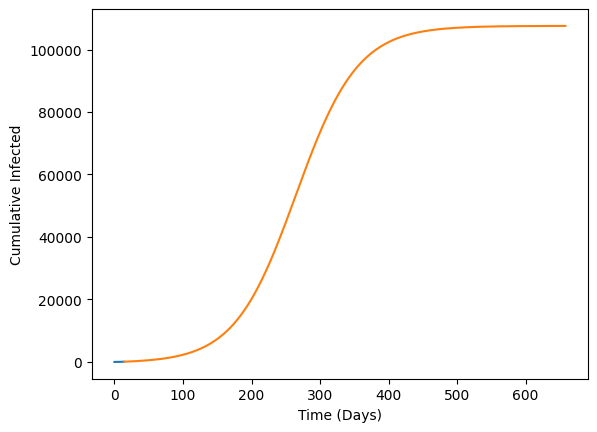

In [ ]:
save_model_fit(archivo_de_datos)

Ajuste con datos hasta cierto periodo de tiempo arbitrario. Para probar el último cacho del ajuste.

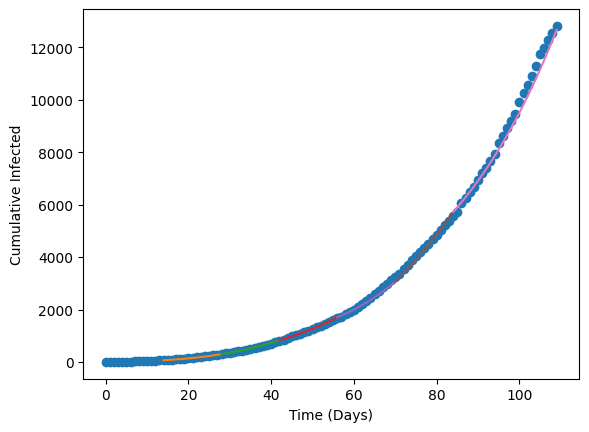

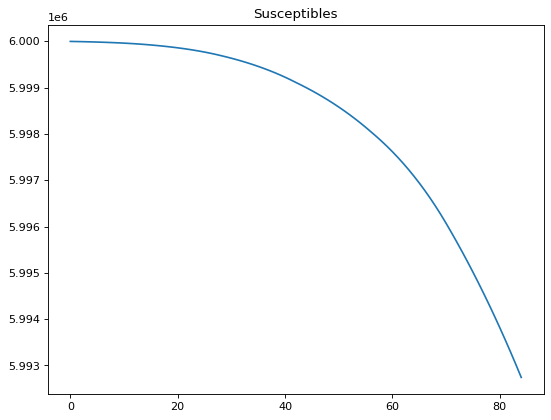

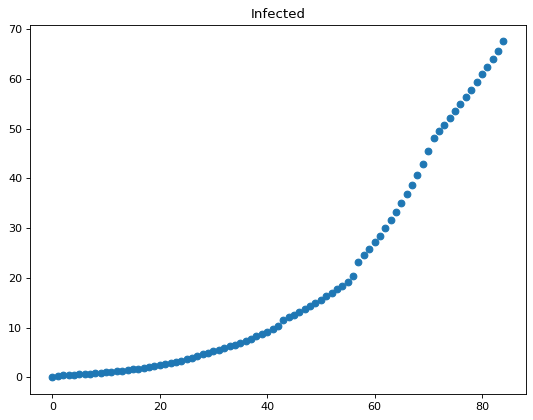

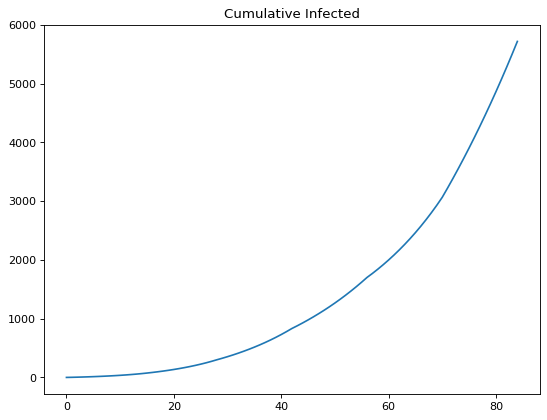

In [ ]:
dat,cum_data=load_data(file=archivo_de_datos)

cum_data=cum_data[:110]

res=fit_in_parts(cum_data)

params = res["params"]
init_times = res["init_times"]
tf = init_times[-1]

def seaird(t,y,u=lambda t : 0.):
        S,E,A,I,R,D,C = y
        N=S+E+A+I+R+D
        mu=0.
        beta,gamma,sigma,eta,alpha = params[init_times <= t][-1]


        dSdt = -beta*(1.-u(t))*(S * E/N + S*A/N + eta*S*I/N)
        dEdt = beta*(1.-u(t))*(S*E/N+ S*A/N+ eta*S*I/N)-sigma*E
        dAdt = alpha*sigma*E-gamma*A
        dIdt = (1.-alpha)*sigma*E - gamma * I
        dRdt = gamma *(A+(1.-mu)*I)
        dDdt = gamma*mu*I
        dCdt = (1.-alpha)*sigma*E

        return np.array([dSdt, dEdt, dAdt, dIdt, dRdt, dDdt, dCdt])

plot_model(seaird,tf)

Para cargar el ajuste hecho anteriormente y graficar el modelo ajustado 

In [ ]:
seaird , tf = load_seaird()
plot_model(seaird,tf)

Graficar Datos :

In [ ]:
data,cum_data = load_data(file=archivo_de_datos)
plot_data(data)
plt.plot(range(len(cum_data)),cum_data)

Cambio de parametros en el tiempo:

In [ ]:
params , init_times = load_seaird_params(file='CovidModel.npy')
t = np.arange(0,init_times[-1]+10,1)
parameters = np.array(list(map(lambda t : params[init_times <= t][-1], t)))
beta = parameters[:,0]
gamma = parameters[:,1]
sigma = parameters[:,2]
eta = parameters[:,3]
alpha = parameters[:,4]
plt.scatter(t,beta)
plt.figure()
plt.scatter(t,gamma)
plt.figure()
plt.scatter(t,sigma)
plt.figure()
plt.scatter(t,eta)
plt.figure()
plt.scatter(t,alpha)
plt.show()

In [ ]:
#GraficarDatosyAjuste()
#Model_Predictive_Control()
#GuardarAjuste()
data,cum_data = load_data(file=archivo_de_datos)
#y0= [5.99868993e+06, 1.63191625e+01, 4.05191237e-03, 2.49010101e+01, 1.26984698e+03, 0.00000000e+00, 1.18612581e+03]
y0=None
guess=None
DT=30
for i in range(1,5):
    y0,guess=predict_evolution(cum_data,i*DT,(i+1)*DT,DT=30,y0=y0,param_guess=guess, plot=True)
    print(y0)
    print(i*DT)

In [ ]:
#save_model_fit()
seaird , tf = load_seaird()
#plot_model(seaird,tf)

S0=6000000.
E0,A0,I0,R0,D0,C0 = 0.,0.,1.,0.,0.,1.
ti=0
y0=[S0,E0,A0,I0,R0,D0,C0]

#J = set_functional_cost(seaird,y0,0.,10.,control_type="Fourier")
evol=receding_horizon_control(seaird,y0,30,tf,control_type="Fourier")

#t = np.linspace(ti, tf, tf)
#evol = solve_ivp(seaird,[ti,tf],y0,t_eval=t, args=(lambda t : 0.5,))
#sol = odeint(seaird,y0,t,args=(lambda t : 0.05,),tfirst=True)
#y = np.transpose(sol)
#evol = {"y":y,"t":t}

plt.title("Susceptibles")
plt.plot(evol["t"],evol["y"][0], label="S")
print(evol["y"][0][-1])
    
plt.figure()
plt.title("Infected")
#plt.plot(evol["t"],sol["y"][1], label="I")
plt.scatter(evol["t"],evol["y"][1], s=1, label="I")
plt.figure()
plt.title("Control")
plt.scatter(evol["t"],evol["u"], s=1)
plt.show()


#plot data
#data,cum_data = load_data()
#plot_data(data)

#fit_in_parts(cum_data)